In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://dlcdn.apache.org/spark/
!wget -q https://dlcdn.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"
import findspark
findspark.init()
findspark.find()
import pyspark

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,848 kB]
Get:13 https://r2u.stat.illinois.edu/ubu

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql import functions as f

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .getOrCreate()
spark

In [5]:
from pyspark.sql import types as T

data_schema = T.StructType([
    T.StructField('contract_id', T.StringType(), False),
    T.StructField('timestamp', T.TimestampType(), False),
    T.StructField('value', T.DoubleType(), True),
    T.StructField('value_source', T.StringType(), False),
    T.StructField('annotations', T.StringType(), True)
])

df_raw_time_series = spark.read.format('json') \
    .schema(data_schema) \
    .load('/content/drive/MyDrive/Colab Notebooks/project/raw_time_series/json')
df_raw_time_series = spark.createDataFrame(df_raw_time_series.rdd, schema=data_schema)
df_raw_time_series.printSchema()
df_raw_time_series.show()

root
 |-- contract_id: string (nullable = false)
 |-- timestamp: timestamp (nullable = false)
 |-- value: double (nullable = true)
 |-- value_source: string (nullable = false)
 |-- annotations: string (nullable = true)

+-------------------+-------------------+--------------------+------------+--------------------+
|        contract_id|          timestamp|               value|value_source|         annotations|
+-------------------+-------------------+--------------------+------------+--------------------+
| 04_02_111 _ CHR12 |2023-01-01 06:00:00| 0.02591860654732236| measurement|{"region":"Europe...|
| 04 _02_111 _CHR12 |2023-01-01 17:00:00| 0.07385444264936832| measurement|{"region":"Europe...|
| 04_02_111 _ CHR12 |2023-01-01 17:30:22| 0.08180149515221906| measurement|{"region":"Europe...|
| 04 _02_111 _CHR12 |2023-01-01 21:30:00| 0.08670661371854547| measurement|{"region":"Europe...|
|04 _ 02 _111_CHR12 |2023-01-02 00:30:00| 0.03597601881331959| measurement|{"region":"Europe...|
|04 

Data clean-up and info extraction progress - if ruled more than once, all values will be turned to NULL

In [6]:
region_schema = T.StructType([
    T.StructField('region', T.StringType(), False)
])

events_schema = T.StructType([
    T.StructField("events", T.StructType([
        T.StructField("EV", T.StringType()),
        T.StructField("PV", T.StringType()),
        T.StructField("BATTERY_IN", T.StringType()),
        T.StructField("BATTERY_OUT", T.StringType()),
        T.StructField("GRID_SELL", T.StringType()),
    ]))
])

df_raw_time_series = (
    df_raw_time_series
    .withColumn('contract_id',
                f.regexp_replace(f.col('contract_id'), ' ', ''))
    .withColumn('value_source',
                f.when(f.col('value').isNull(), 'missing').otherwise(f.col('value_source')))
    .withColumn('timestamp',
                f.from_unixtime(f.round(f.unix_timestamp('timestamp') / (15 * 60)) * (15 * 60)))
    .withColumn('timestamp',
                f.date_format('timestamp', 'yyyy-MM-dd HH:mm'))
    .withColumn('region',
                f.from_json(f.col('annotations'), region_schema).getField('region'))
    .filter(~((f.col('region').isNull()) |
            (f.trim(f.col('region')) == '') |
            (f.regexp_extract(f.col('region'), r'^[A-Za-z]+(?:[\s-][A-Za-z]+)*\/[A-Za-z]+(?:[\s-][A-Za-z]+)*$', 0) == '')))
    .withColumn('utc_date',
                f.date_format('timestamp', 'yyyy-MM-dd'))
    .withColumn("local_timestamp",
                f.from_utc_timestamp(f.col('timestamp'), f.col("region")))
    .withColumn("local_date",
                f.to_date(f.col("local_timestamp")))
    .withColumn("annotation_json",
                f.from_json(f.col("annotations"), events_schema))
    .withColumn("sent_to_ev",
                f.coalesce(f.col("annotation_json.events.EV").cast(T.DoubleType()), f.lit(0)))
    .withColumn("received_from_pv",
                f.coalesce(f.col("annotation_json.events.PV").cast(T.DoubleType()), f.lit(0)))
    .withColumn("sent_to_battery",
                f.coalesce(f.col("annotation_json.events.BATTERY_IN").cast(T.DoubleType()), f.lit(0)))
    .withColumn("received_from_battery",
                f.coalesce(f.col("annotation_json.events.BATTERY_OUT").cast(T.DoubleType()), f.lit(0)))
    .withColumn("sent_to_grid",
                f.coalesce(f.col("annotation_json.events.GRID_SELL").cast(T.DoubleType()), f.lit(0)))
    .drop("annotation_json")
    .drop("annotations")
)

df_raw_time_series.show()

+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+
|    contract_id|       timestamp|               value|value_source|       region|  utc_date|    local_timestamp|local_date|sent_to_ev|received_from_pv|sent_to_battery|received_from_battery|sent_to_grid|
+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+
|04_02_111_CHR12|2023-01-01 06:00| 0.02591860654732236| measurement|Europe/Berlin|2023-01-01|2023-01-01 07:00:00|2023-01-01|       0.0|             0.0|            0.0|                  0.0|         0.0|
|04_02_111_CHR12|2023-01-01 17:00| 0.07385444264936832| measurement|Europe/Berlin|2023-01-01|2023-01-01 18:00:00|2023-01-01|       0.0|             0.0|            0.0|                

Setarea coloanei „value_source” în „plausability_check_failed” pentru valorile cu consum neobișnuit din setul de date.
- Decizia valorilor mari fie se face cu o analiză vizuală a datelor (sortarea și identificarea lor vizual fie prin agregări simple fie mai complicate) sau bonus, pentru cine dorește, prin tehnici de învățare automată.


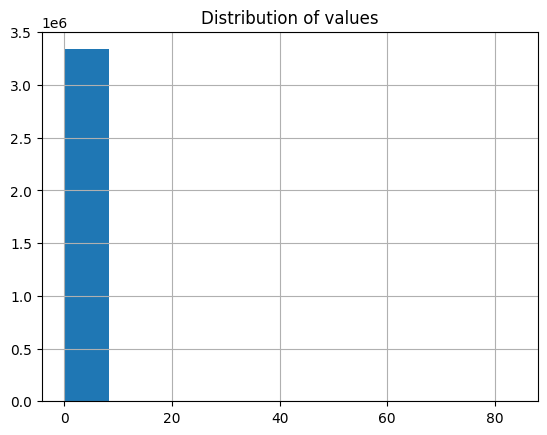

In [7]:
# histogram / density plot

df_values = df_raw_time_series.select('value').toPandas()
df_values.hist()
plt.title('Distribution of values')
plt.show()

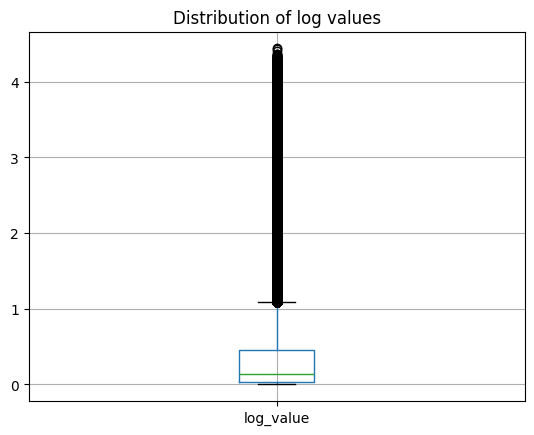

In [8]:
# log scale

df_values['log_value'] = np.log1p(df_values['value'])
df_values.boxplot(column='log_value')
plt.title('Distribution of log values')
plt.show()

In [15]:
# z-score
outlier_limit = 5

# mean and standard deviation
mean_value = df_raw_time_series.select(f.mean('value')).first()[0]
std_value = df_raw_time_series.select(f.stddev('value')).first()[0]

# z-scores and filter for outliers
print("Mean value:", mean_value)
print("Standard deviation:", std_value)
outliers = df_raw_time_series.withColumn('z_score', (f.col('value') - mean_value) / std_value) \
                              .filter(f.abs('z_score') < outlier_limit)
outliers.select('contract_id', 'timestamp', 'value', 'z_score').show(300, truncate=False)

Mean value: 0.49049897443150375
Standard deviation: 1.528242575319825
+---------------+----------------+--------------------+--------------------+
|contract_id    |timestamp       |value               |z_score             |
+---------------+----------------+--------------------+--------------------+
|04_02_111_CHR12|2023-01-01 06:00|0.02591860654732236 |-0.30399648287966047|
|04_02_111_CHR12|2023-01-01 17:00|0.07385444264936832 |-0.2726298419574796 |
|04_02_111_CHR12|2023-01-01 17:30|0.08180149515221906 |-0.26742971690456535|
|04_02_111_CHR12|2023-01-01 21:30|0.08670661371854547 |-0.26422007031734085|
|04_02_111_CHR12|2023-01-02 00:30|0.03597601881331959 |-0.2974154515509838 |
|04_02_111_CHR12|2023-01-02 05:30|0.03638379308965683 |-0.29714862592858426|
|04_02_111_CHR12|2023-01-03 10:45|0.931575            |0.2886165015237777  |
|04_02_111_CHR12|2023-01-03 18:30|0.08816273670606922 |-0.26326726150868757|
|04_02_111_CHR12|2023-01-04 08:00|0.01782329751018486 |-0.3092936190593951 |
|04_02

In [23]:
outliers.count()

3337415

In [16]:
# quantile approximation
quantiles = df_raw_time_series.approxQuantile('value', [0.95], 0.01)
print("Quantile threshold:", quantiles[0])

df_updated = df_raw_time_series.withColumn(
    'value_source',
    f.when(f.col('value') > quantiles[0], 'plausability_check_failed').otherwise(f.col('value_source')))
df_updated.select('contract_id', 'timestamp', 'value', 'value_source').show(300, truncate=False)

Quantile threshold: 1.661425
+---------------+----------------+--------------------+-------------------------+
|contract_id    |timestamp       |value               |value_source             |
+---------------+----------------+--------------------+-------------------------+
|04_02_111_CHR12|2023-01-01 06:00|0.02591860654732236 |measurement              |
|04_02_111_CHR12|2023-01-01 17:00|0.07385444264936832 |measurement              |
|04_02_111_CHR12|2023-01-01 17:30|0.08180149515221906 |measurement              |
|04_02_111_CHR12|2023-01-01 21:30|0.08670661371854547 |measurement              |
|04_02_111_CHR12|2023-01-02 00:30|0.03597601881331959 |measurement              |
|04_02_111_CHR12|2023-01-02 05:30|0.03638379308965683 |measurement              |
|04_02_111_CHR12|2023-01-03 10:45|0.931575            |measurement              |
|04_02_111_CHR12|2023-01-03 18:30|0.08816273670606922 |measurement              |
|04_02_111_CHR12|2023-01-04 06:30|NULL                |missing       

In [24]:
df_updated.count()

3444112

In [22]:
df_updated.select('contract_id', 'timestamp', 'value', 'value_source') \
  .filter(f.col('value_source') == 'plausability_check_failed') \
  .orderBy(f.col('value')) \
  .show(2000, truncate=False)

+---------------+----------------+------------------+-------------------------+
|contract_id    |timestamp       |value             |value_source             |
+---------------+----------------+------------------+-------------------------+
|10_01_147_CHR61|2023-05-23 13:00|1.661435214035643 |plausability_check_failed|
|04_02_111_CHS01|2023-03-28 15:15|1.661475114177063 |plausability_check_failed|
|10_01_147_CHR11|2023-06-14 07:15|1.661563125       |plausability_check_failed|
|04_02_111_CHR48|2023-01-26 13:00|1.6615699949852787|plausability_check_failed|
|10_01_147_CHR14|2023-05-29 13:15|1.6615875373872577|plausability_check_failed|
|04_02_111_CHR56|2023-01-25 20:45|1.661606768181765 |plausability_check_failed|
|04_02_111_CHR37|2023-01-03 17:45|1.6616157124614719|plausability_check_failed|
|04_02_111_CHS01|2023-07-12 14:30|1.661615747657321 |plausability_check_failed|
|04_02_111_CHR05|2023-03-28 15:15|1.6616465787561343|plausability_check_failed|
|10_01_147_CHR49|2023-11-06 13:30|1.6616

In [11]:
# bonus: k-means
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['value'], outputCol='features')
data_assembler = assembler.transform(df_raw_time_series)

kmeans = KMeans(featuresCol="features", k=3)
model = kmeans.fit(data_assembler)

predictions = model.transform(data_assembler)
predictions.groupBy('prediction').agg(f.mean('value'), f.stddev('value')).show()

Py4JJavaError: An error occurred while calling o241.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 13.0 failed 1 times, most recent failure: Lost task 1.0 in stage 13.0 (TID 41) (26bb5e5d710e executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3983/0x0000000841616840`: (struct<value:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3983/0x0000000841616840`: (struct<value:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more
